In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
import seaborn as sns
import time
from itertools import product
from tqdm import tqdm

%matplotlib inline

In [2]:
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

In [3]:
# Lambda = 450
Lambda = 500

high_density = False
if high_density:
    filename = '../data/all_matter_data_high_density.csv'
else:
    filename = '../data/all_matter_data.csv'
    
data = InputData(filename, Lambda, high_density)

In [4]:
orders = np.array([0, 2, 3, 4])
# orders_appended = np.array([0, 2, 3, 4, 3, 4])
orders_appended = np.array([0, 2, 3, 3, 4, 4])

body2 = 'NN-only'
body23 = 'NN+3N'
body3 = '3N'
body23_appended = 'Appended'

pure_neutron = 'pure'
sym_nuclear = 'sym'
# avg_momentum = 'avg'
s2_energy = 's2'

train = slice(None, None, 4)
valid = slice(2, None, 4)


excluded_2bf = np.array([0, 1])
# excluded_2bf = np.array([1])
excluded_3bf = np.array([0, 1, 2])

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None


# The Gaussian process parameters
nugget = 1e-6

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref_2bf = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=0,
    scale=1,
)

# optimizer = None



In [5]:
kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s
kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

ref_2bf = data.ref_2bf
ref_n_3bf = data.ref_n_3bf / kf_n**3
ref_s_3bf = data.ref_s_3bf / kf_s**3
ref_d_3bf = data.ref_avg_3bf / kf_d**3

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

In [6]:
from nuclear_matter.matter import ratio_density

In [7]:
data.density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21])

In [8]:
data.density[train]

array([0.05, 0.09, 0.13, 0.17, 0.21])

In [9]:
data.density[valid]

array([0.07, 0.11, 0.15, 0.19])

In [10]:
Q_n = ratio_kf(data.Kf_n, breakdown=Lb)
Q_s = ratio_kf(data.Kf_s, breakdown=Lb)
Q_d = ratio_kf(data.Kf_avg, breakdown=Lb)

Lb_rho = 40
Q_n_rho = ratio_kf(data.density, breakdown=Lb_rho)
Q_s_rho = ratio_kf(data.density, breakdown=Lb_rho)
# Q_d = ratio_kf(Kf_d, breakdown=Lb)

In [11]:
def concatenate_2bf_and_3bf_coefficients(c2, c3):
    return np.concatenate([c2[:, :-1], c3[:, [2]], c2[:, [-1]], c3[:, [3]]], axis=1)

In [12]:
coeffs_s_2_plus_3bf = gm.coefficients(y_s_2_plus_3bf, Q_s, ref_2bf, orders=orders)
coeffs_n_2_plus_3bf = gm.coefficients(y_n_2_plus_3bf, Q_n, ref_2bf, orders=orders)
coeffs_d_2_plus_3bf = gm.coefficients(y_d_2_plus_3bf, Q_d, ref_2bf, orders=orders)

coeffs_n_2bf = gm.coefficients(y_n_2bf, Q_n, ref_2bf, orders=orders)
coeffs_s_2bf = gm.coefficients(y_s_2bf, Q_s, ref_2bf, orders=orders)
coeffs_d_2bf = gm.coefficients(y_d_2bf, Q_d, ref_2bf, orders=orders)

coeffs_n_3bf = gm.coefficients(y_n_3bf, Q_n, ref_n_3bf, orders=orders)
coeffs_s_3bf = gm.coefficients(y_s_3bf, Q_s, ref_s_3bf, orders=orders)
coeffs_d_3bf = gm.coefficients(y_d_3bf, Q_d, ref_d_3bf, orders=orders)


coeffs_n_appended = concatenate_2bf_and_3bf_coefficients(coeffs_n_2bf, coeffs_n_3bf)
coeffs_s_appended = concatenate_2bf_and_3bf_coefficients(coeffs_s_2bf, coeffs_s_3bf)
coeffs_d_appended = concatenate_2bf_and_3bf_coefficients(coeffs_d_2bf, coeffs_d_3bf)

y_n_appended = gm.partials(coeffs_n_appended, ratio=Q_n[:, None], ref=ref_2bf, orders=orders_appended)
y_s_appended = gm.partials(coeffs_s_appended, ratio=Q_s[:, None], ref=ref_2bf, orders=orders_appended)
y_d_appended = gm.partials(coeffs_d_appended, ratio=Q_d[:, None], ref=ref_2bf, orders=orders_appended)

# coeffs_n_2_plus_3bf = gm.coefficients(y_n_2_plus_3bf, Q_n_rho, ref_2bf, orders=orders)
# coeffs_s_2_plus_3bf = gm.coefficients(y_s_2_plus_3bf, Q_s_rho, ref_2bf, orders=orders)
# # coeffs_d_2_plus_3bf = gm.coefficients(y_d_2_plus_3bf, Q_d, ref_2bf, orders=orders)

# coeffs_n_2bf = gm.coefficients(y_n_2bf, Q_n_rho, ref_2bf, orders=orders)
# coeffs_s_2bf = gm.coefficients(y_s_2bf, Q_s_rho, ref_2bf, orders=orders)
# # coeffs_d_2bf = gm.coefficients(y_d_2bf, Q_d, ref_2bf, orders=orders)

# coeffs_n_3bf = gm.coefficients(y_n_3bf, Q_n_rho, ref_n_3bf_vals, orders=orders)
# coeffs_s_3bf = gm.coefficients(y_s_3bf, Q_s_rho, ref_s_3bf_vals, orders=orders)
# # coeffs_d_3bf = gm.coefficients(y_d_3bf, Q_d, ref_d_3bf, orders=orders)

Text(0.5, 0, '$n$ [fm$^{-3}$]')

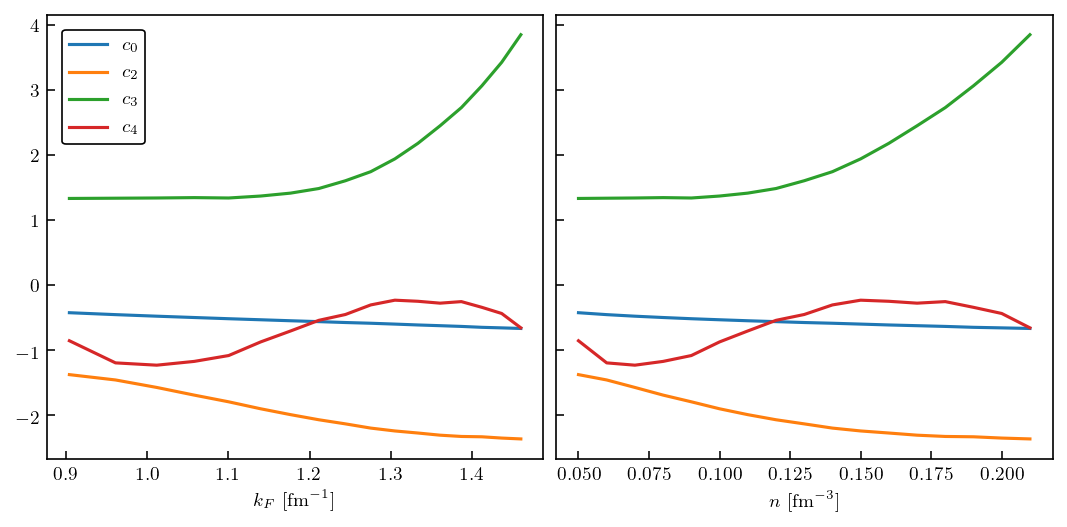

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharey=True)
for i, n in enumerate(orders):
    axes[0].plot(kf_s, coeffs_s_2_plus_3bf[:, i], label=fr'$c_{n}$')
    axes[1].plot(density, coeffs_s_2_plus_3bf[:, i])
axes[0].legend()
axes[0].set_xlabel(r'$k_F$ [fm$^{-1}$]')
axes[1].set_xlabel(r'$n$ [fm$^{-3}$]')

In [14]:
coeffs_n_appended.shape

(17, 6)

In [15]:
coeffs_n_appended.shape

(17, 6)

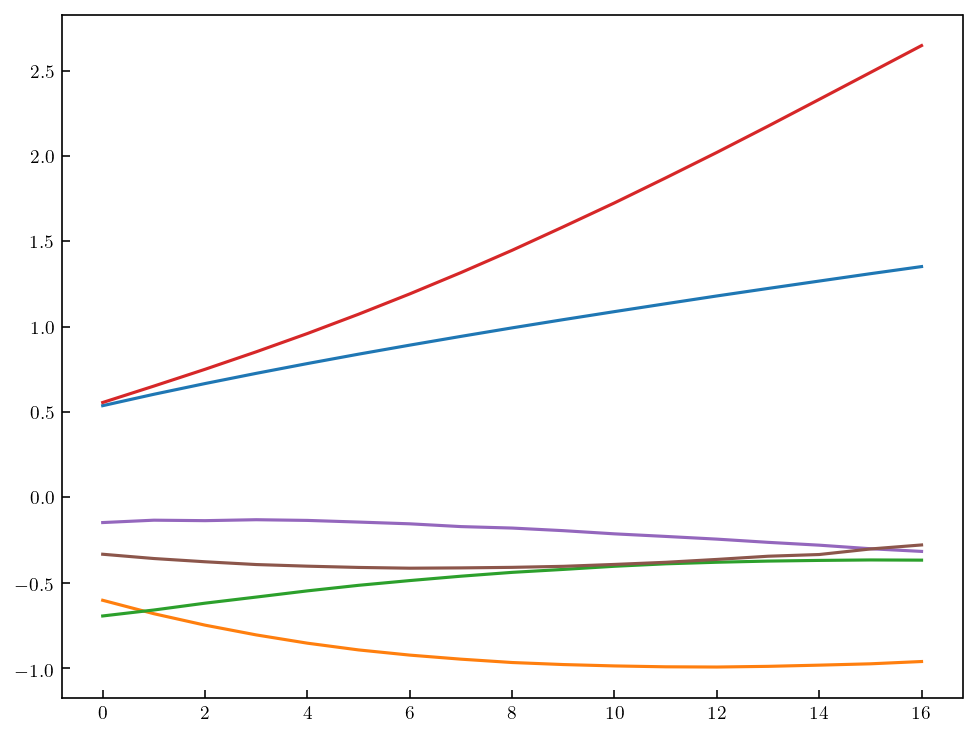

In [16]:
plt.plot(coeffs_n_appended)

In [17]:
coeffs_s_3bf

array([[0.        , 0.        , 1.78881544, 0.64408011],
       [0.        , 0.        , 1.79276935, 0.77614019],
       [0.        , 0.        , 1.77967669, 0.96537731],
       [0.        , 0.        , 1.76657233, 1.19868806],
       [0.        , 0.        , 1.76693996, 1.45971218],
       [0.        , 0.        , 1.78919307, 1.71575084],
       [0.        , 0.        , 1.84178398, 1.96116612],
       [0.        , 0.        , 1.9316806 , 2.17215171],
       [0.        , 0.        , 2.05439989, 2.35886616],
       [0.        , 0.        , 2.21467596, 2.52441396],
       [0.        , 0.        , 2.42260816, 2.62455685],
       [0.        , 0.        , 2.66186272, 2.71330348],
       [0.        , 0.        , 2.94639383, 2.74454415],
       [0.        , 0.        , 3.26102996, 2.75853328],
       [0.        , 0.        , 3.61020897, 2.74062597],
       [0.        , 0.        , 3.99836213, 2.67025594],
       [0.        , 0.        , 4.42718589, 2.55506713]])

In [18]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]

In [19]:
# use_kf = True

kf_x_label = r'$k_F$ [fm$^{-1}$]'
density_x_label = r'$\rho$ [fm$^{-3}$]'

# if use_kf:
#     x_n = kf_n
#     x_s = kf_s
#     x_d = kf_d
#     x_label = kf_x_label
#     x_save = 'use-kf'
# else:
#     x_n = x_s = x_d = density
#     x_label = density_x_label
    
#     x_save = 'use-rho'

In [20]:
def plot_coefficients(kf, d, coeffs_2bf, coeffs_3bf, coeffs_23bf, orders, colors):
    fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), sharey=True, sharex='col')
    for i, n in enumerate(orders):

        axes[0, 0].plot(kf, coeffs_23bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
        axes[0, 0].plot(kf[train], coeffs_23bf[train, i], c=colors[i], ls='', marker='o')
        axes[1, 0].plot(kf, coeffs_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
        if n > 2:
            axes[1, 0].plot(kf, coeffs_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

        axes[0, 1].plot(d, coeffs_23bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
        axes[1, 1].plot(d, coeffs_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
        if n > 2:
            axes[1, 1].plot(d, coeffs_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

    for ax in axes.ravel():
        ax.axhline(0, 0, 1, c='lightgrey', zorder=0)
        ax.tick_params(direction='in')
    axes[1, 0].set_xlabel(kf_x_label)
    axes[1, 1].set_xlabel(density_x_label)
    axes[0, 0].legend(ncol=2)
    axes[1, 0].legend(ncol=3)
#     fig.tight_layout(h_pad=0.3, w_pad=0.3)
    return fig, axes

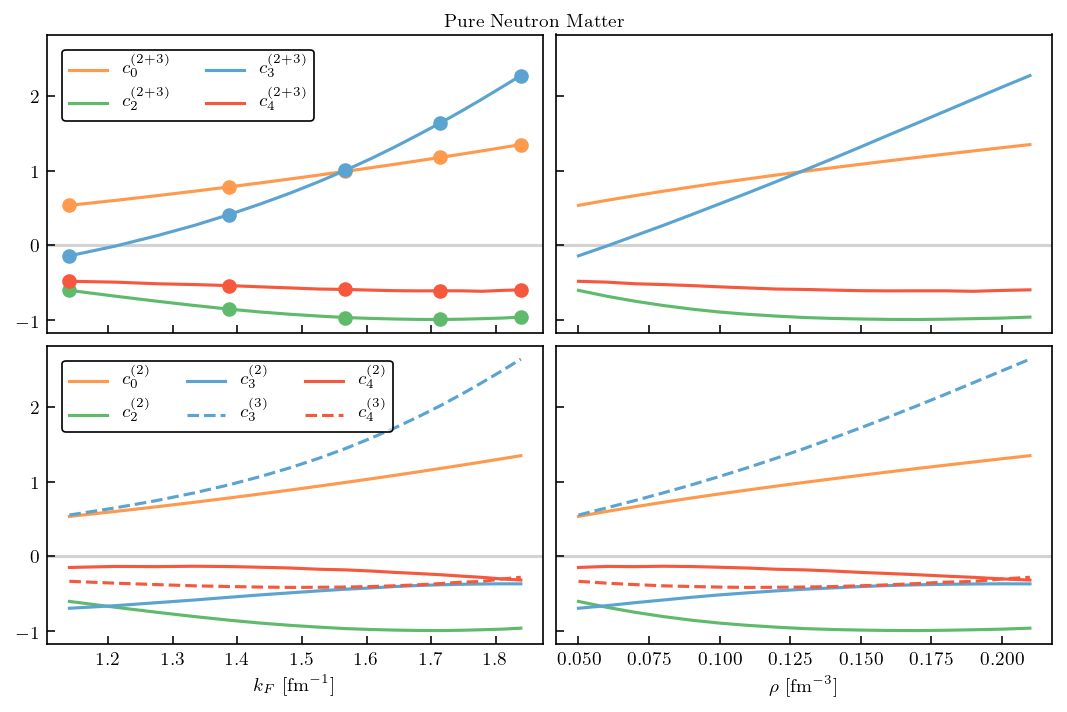

In [21]:
fig, axes = plot_coefficients(
    kf_n, density, coeffs_2bf=coeffs_n_2bf, coeffs_3bf=coeffs_n_3bf,
    coeffs_23bf=coeffs_n_2_plus_3bf, orders=orders, colors=colors)
fig.suptitle('Pure Neutron Matter', y=1.02)

fig.savefig(f'coeffs_neutron_matter_compare_2bf_3bf')

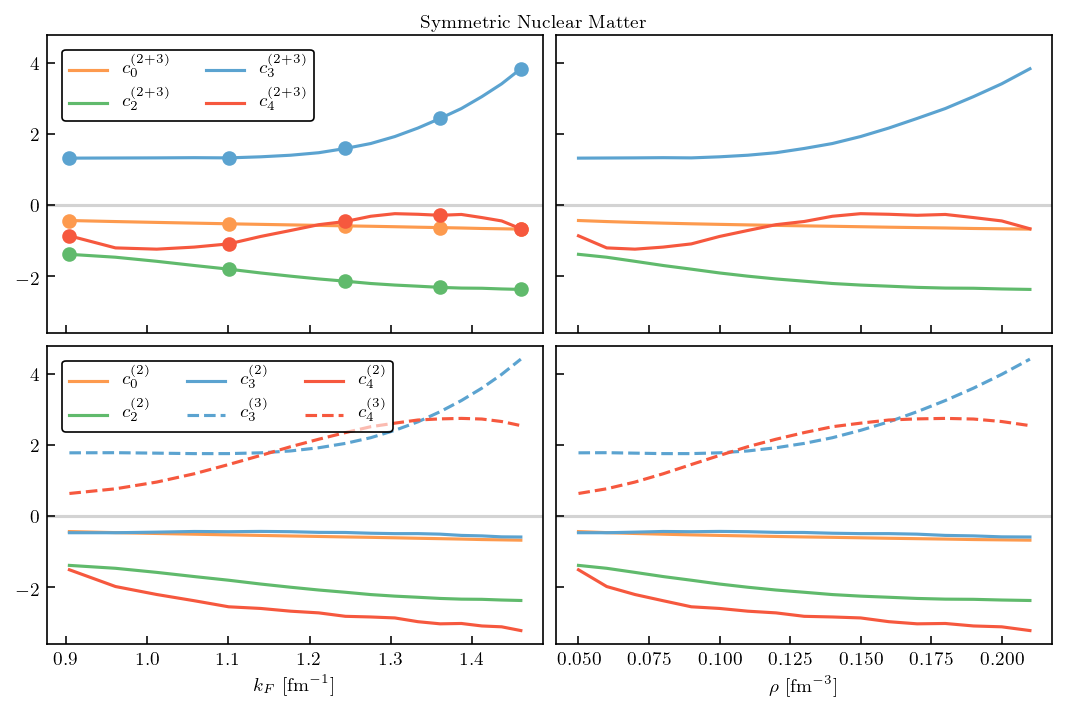

In [22]:
fig, axes = plot_coefficients(
    kf_s, density, coeffs_2bf=coeffs_s_2bf, coeffs_3bf=coeffs_s_3bf,
    coeffs_23bf=coeffs_s_2_plus_3bf, orders=orders, colors=colors)
fig.suptitle('Symmetric Nuclear Matter', y=1.02)
fig.savefig(f'coeffs_nuclear_matter_compare_2bf_3bf')

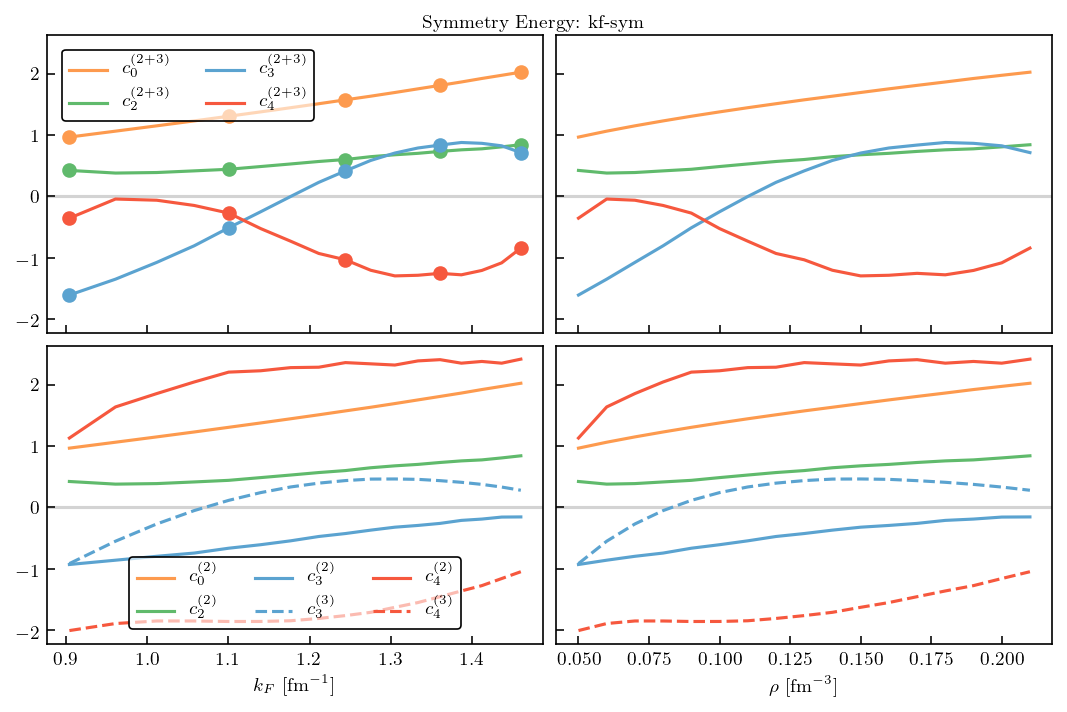

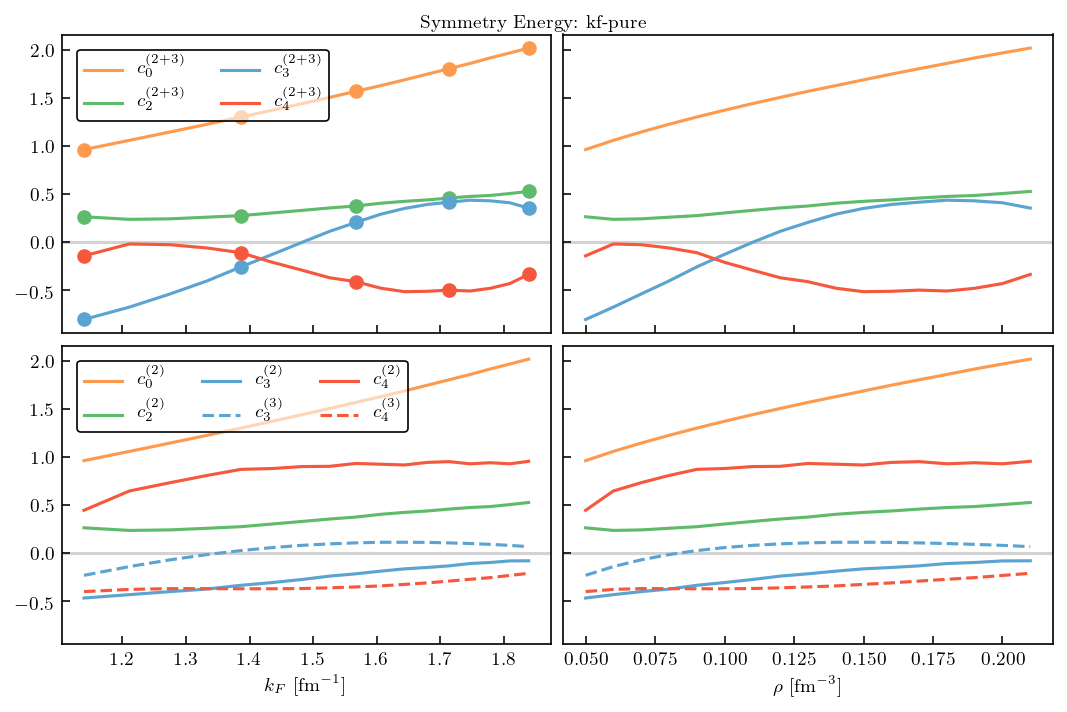

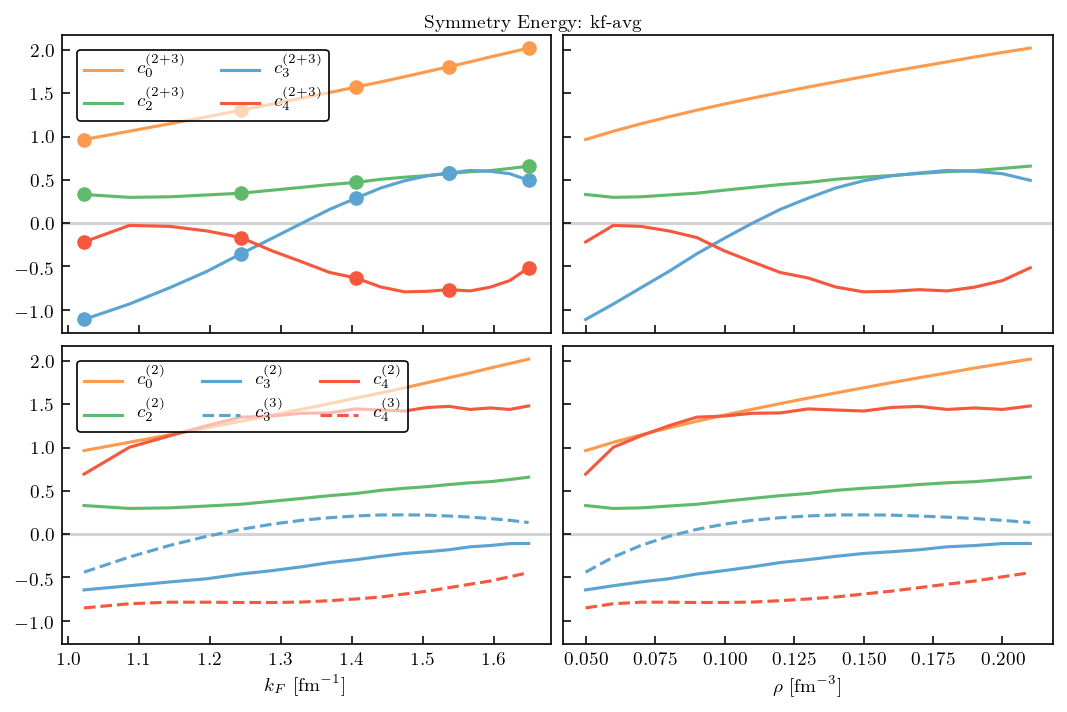

In [23]:
for kf_type_, kf_i in zip(['kf-sym', 'kf-pure', 'kf-avg'], [kf_s, kf_n, (kf_s+kf_n)/2.]):
    
    Q_d_i = ratio_kf(kf_i[:, None], breakdown=Lb)
    ref_d_3bf_i = 16 * kf_i**3
    coeffs_d_2_plus_3bf_i = gm.coefficients(y_d_2_plus_3bf, Q_d_i, ref_2bf, orders=orders)
    coeffs_d_2bf_i = gm.coefficients(y_d_2bf, Q_d_i, ref_2bf, orders=orders)
    coeffs_d_3bf_i = gm.coefficients(y_d_3bf, Q_d_i, ref_d_3bf_i, orders=orders)
    
    fig, axes = plot_coefficients(
        kf_i, density, coeffs_2bf=coeffs_d_2bf_i, coeffs_3bf=coeffs_d_3bf_i,
        coeffs_23bf=coeffs_d_2_plus_3bf_i, orders=orders, colors=colors)

    fig.suptitle(f'Symmetry Energy: {kf_type_}', y=1.02)
    fig.savefig(f'coeffs_symmetry_energy_compare_2bf_3bf_{kf_type_}')

## Convergence Analysis

In [24]:
def ref_cubic_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel() ** 3

def ref_linear_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel()


ref_3bf_func = ref_linear_3bf

This is not quite right: should put the 3BF corrections right after the 2BF corrections

In [25]:
# def create_appended_y(y2, y3, y2_ref, y3_ref):
#     y2 = y2.copy()
#     diff = y2[:, [-1]] + y2_ref * y3[:, 2:] / y3_ref
#     return np.append(y2, diff, axis=1)

In [26]:
# y_n_app = create_appended_y(y_n_2bf, y_n_3bf, ref_2bf, ref_3bf_func(kf_n)[:, None])
# y_s_app = create_appended_y(y_s_2bf, y_s_3bf, ref_2bf, ref_3bf_func(kf_s)[:, None])
# y_d_app = create_appended_y(y_d_2bf, y_d_3bf, ref_2bf, ref_3bf_func(kf_avg)[:, None])

In [27]:
c_n_app = gm.coefficients(y_n_appended, Q_n, ref_2bf, orders=orders_appended)
c_s_app = gm.coefficients(y_s_appended, Q_s, ref_2bf, orders=orders_appended)
c_d_app = gm.coefficients(y_d_appended, Q_d, ref_2bf, orders=orders_appended)

Text(0.5, 1.02, 'Pure Neutron Matter')

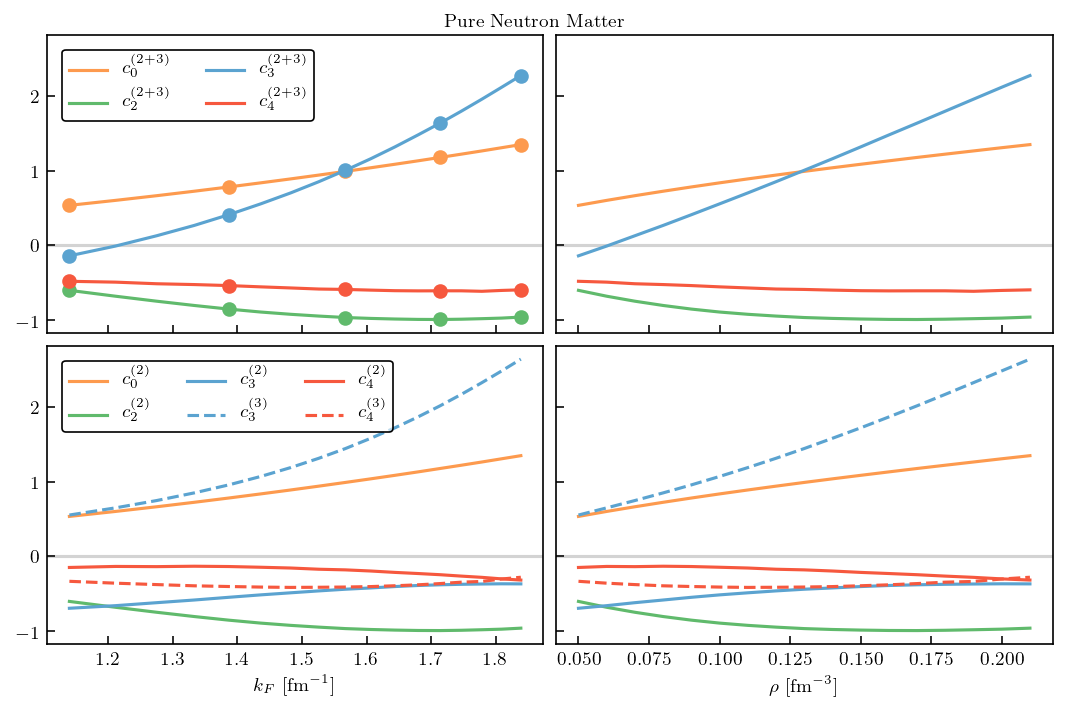

In [28]:
fig, axes = plot_coefficients(
    kf_n, density, coeffs_2bf=coeffs_n_2bf, coeffs_3bf=coeffs_n_3bf,
    coeffs_23bf=coeffs_n_2_plus_3bf, orders=orders, colors=colors)
fig.suptitle('Pure Neutron Matter', y=1.02)

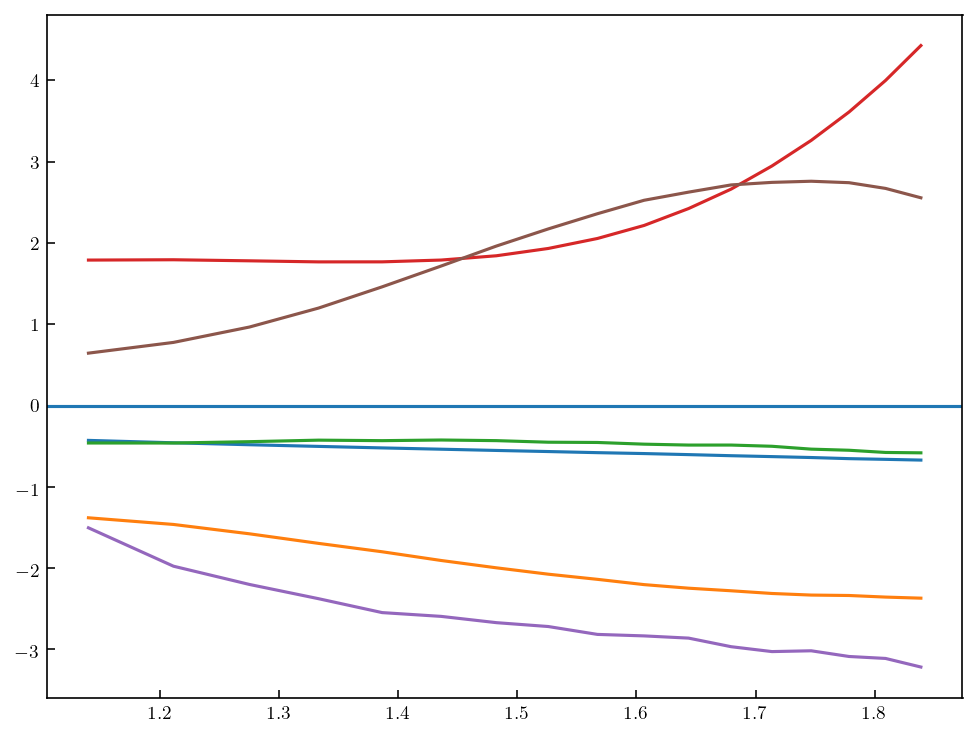

In [29]:
plt.plot(kf_n, c_s_app);
plt.axhline(0, 0, 1)

In [30]:
kf_n * hbar_c

array([224.89752844, 238.98864951, 251.58995173, 263.04083754,
       273.5741528 , 283.35170565, 292.49978537, 301.10718911,
       309.24890113, 316.98411953, 324.35822952, 331.4106965 ,
       338.17703933, 344.68093725, 350.95001604, 357.00203513,
       362.85475395])

In [31]:
0.12, 3.2

(0.12, 3.2)

In [32]:
density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21])

In [33]:
nuclear_density(600 / hbar_c, 2)

0.9494524318991496

In [34]:
nuclear_density(600 / hbar_c, 4)

1.8989048637982993

In [35]:
fermi_momenta = {
    pure_neutron: kf_n,
    sym_nuclear: kf_s,
    s2_energy: kf_d
}

Fermi_momenta = {
    pure_neutron: Kf_n,
    sym_nuclear: Kf_s,
    s2_energy: Kf_d
}

refs = {
    # E/N
    (pure_neutron, body2): ref_2bf,
    (pure_neutron, body3): ref_3bf_func,
    (pure_neutron, body23): ref_2bf,
    (pure_neutron, body23_appended): ref_2bf,
    # E/A
    (sym_nuclear, body2): ref_2bf,
    (sym_nuclear, body3): ref_3bf_func,
    (sym_nuclear, body23): ref_2bf,
    (sym_nuclear, body23_appended): ref_2bf,
    # S2
    (s2_energy, body2): ref_2bf,
    (s2_energy, body3): ref_3bf_func,
    (s2_energy, body23): ref_2bf,
    (s2_energy, body23_appended): ref_2bf,
}

# S2_observables = {
#     body2: y_d_2bf,
#     body3: y_d_3bf,
#     body23: y_d_2_plus_3bf,
# }
observables = {
    # E/N
    (pure_neutron, body2): y_n_2bf,
    (pure_neutron, body3): y_n_3bf,
    (pure_neutron, body23): y_n_2_plus_3bf,
#     (pure_neutron, body23_appended): y_n_app,
    (pure_neutron, body23_appended): y_n_appended,
    # E/A
    (sym_nuclear, body2): y_s_2bf,
    (sym_nuclear, body3): y_s_3bf,
    (sym_nuclear, body23): y_s_2_plus_3bf,
#     (sym_nuclear, body23_appended): y_s_app,
    (sym_nuclear, body23_appended): y_s_appended,
    # S2
    (s2_energy, body2): y_d_2bf,
    (s2_energy, body3): y_d_3bf,
    (s2_energy, body23): y_d_2_plus_3bf,
#     (s2_energy, body23_appended): y_d_app,
#     (s2_energy, body23_appended): y_d_appended,
}

excluded_orders = {
    body2: excluded_2bf,
    body3: excluded_3bf,
    body23: excluded_2bf,
    body23_appended: excluded_2bf,
}

obs_types = [pure_neutron, sym_nuclear, s2_energy]
systems = {pure_neutron: 'neutron', sym_nuclear: 'symmetric', s2_energy: 'difference'}
body_types = [body2, body3, body23, body23_appended]

In [36]:
analyses = {}

with tqdm(total=len(obs_types) * len(body_types)) as pbar:
    for obs_type in obs_types:
        X_i = Fermi_momenta[obs_type]
        y2_i = observables[obs_type, body2]
        y3_i = observables[obs_type, body23]
        ref2_i = refs[obs_type, body2]
        ref3_i = refs[obs_type, body3]
        for n_body in body_types:
            pbar.set_postfix(obs_type=obs_type, n_body=n_body, refresh=True)
            ex_i = excluded_orders[n_body]
            system_i = systems[obs_type]
            orders_i = orders.copy()

            if n_body == body23_appended:
                max_idxs = [3, 5]
                max_idx_labels = [2, 3]
#                 orders_i = orders_appended
            else:
                max_idxs = [2, 3]
                max_idx_labels = None
#                 orders_i = orders

            analyses[obs_type, n_body] = MatterConvergenceAnalysis(
                X=X_i, y2=y2_i, y3=y3_i, orders=orders_i, train=train, valid=valid,
                ref2=ref2_i, ref3=ref3_i, ratio='kf', density=density,
                kernel=kernel, system=system_i, fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
                body=n_body, savefigs=savefigs, excluded=ex_i,
#                 optimizer=optimizer,
                decomposition='eig', **hyperparams
            )

            analyses[obs_type, n_body].setup_posteriors(
                breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
                ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
                max_idx=max_idxs, logprior=None, max_idx_labels=max_idx_labels
            )
            pbar.update(1)

 25%|██▌       | 3/12 [00:29<01:31, 10.17s/it, n_body=Appended, obs_type=pure]

Appending 2bf and 3bf predictions...
Reseting orders to be [0 2 3 3 4 4]


 58%|█████▊    | 7/12 [01:09<00:49,  9.97s/it, n_body=Appended, obs_type=sym] 

Appending 2bf and 3bf predictions...
Reseting orders to be [0 2 3 3 4 4]


 92%|█████████▏| 11/12 [01:49<00:10, 10.17s/it, n_body=Appended, obs_type=s2]

Appending 2bf and 3bf predictions...
Reseting orders to be [0 2 3 3 4 4]


100%|██████████| 12/12 [01:59<00:00,  9.92s/it, n_body=Appended, obs_type=s2]


RBF(length_scale=0.393) + WhiteKernel(noise_level=1e-06)
cbar mean: 2.385987965622481


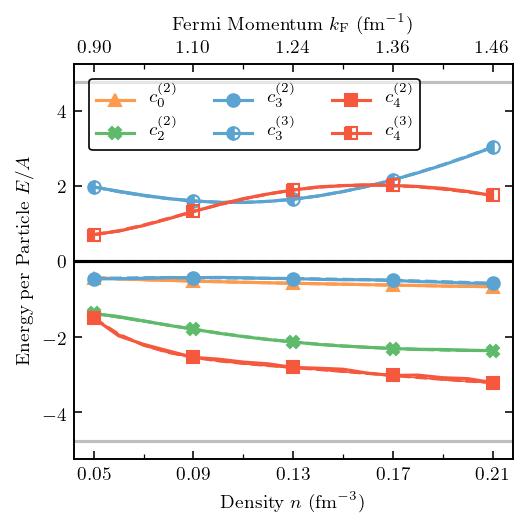

In [37]:
analyses[sym_nuclear, body23_appended].plot_coefficients(show_excluded=True, show_process=True, breakdown=Lb)

RBF(length_scale=0.393) + WhiteKernel(noise_level=1e-06)
cbar mean: 2.385987965622481


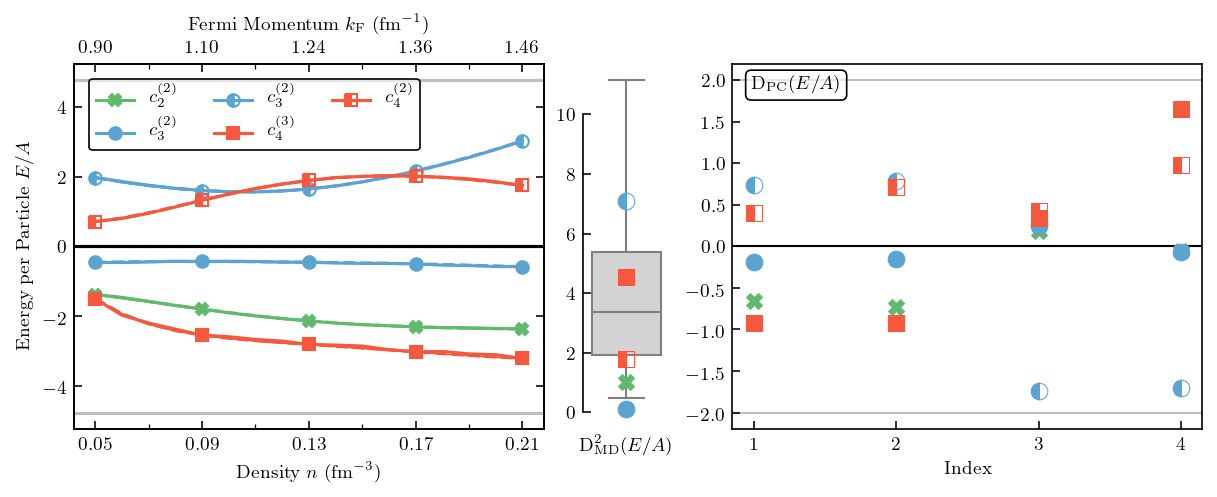

In [38]:
analyses[sym_nuclear, body23_appended].plot_coeff_diagnostics(breakdown=Lb);

RBF(length_scale=0.851) + WhiteKernel(noise_level=1e-06)
cbar mean: 0.8888244512654769


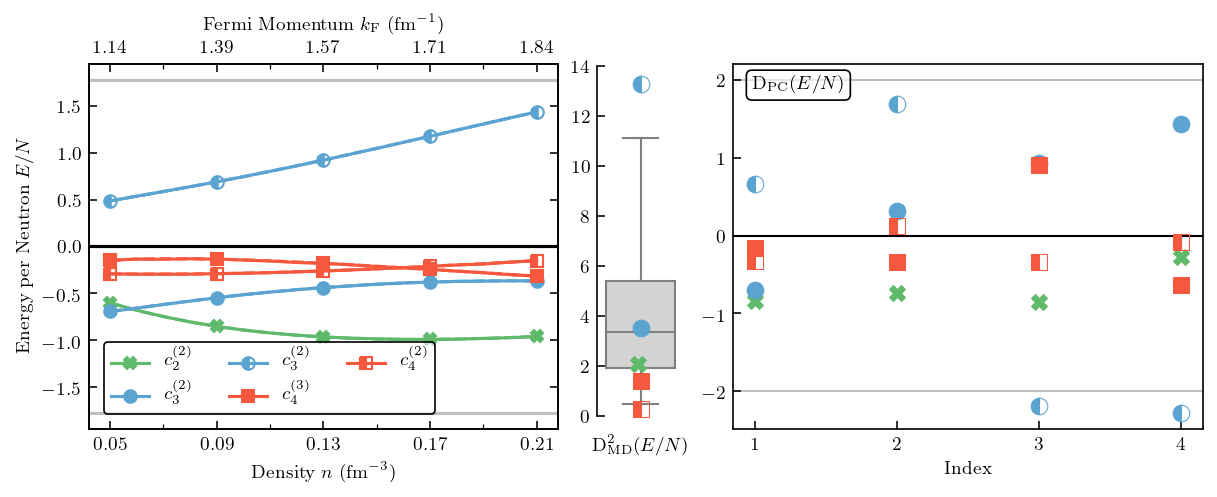

In [39]:
analyses[pure_neutron, body23_appended].plot_coeff_diagnostics(breakdown=Lb);

RBF(length_scale=0.369) + WhiteKernel(noise_level=1e-06)
cbar mean: 0.7926834405402076


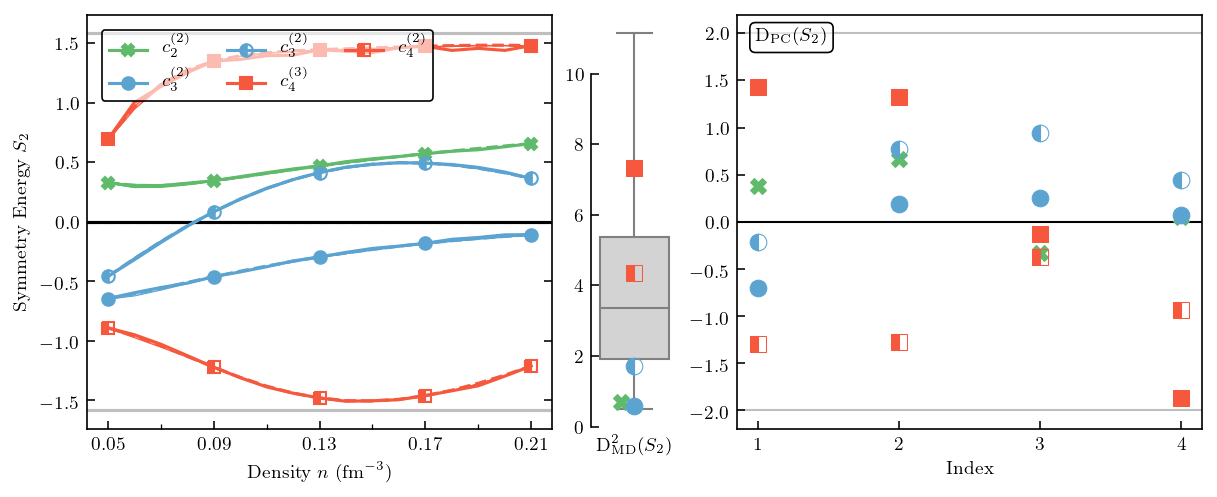

In [40]:
analyses[s2_energy, body23_appended].plot_coeff_diagnostics(breakdown=Lb);

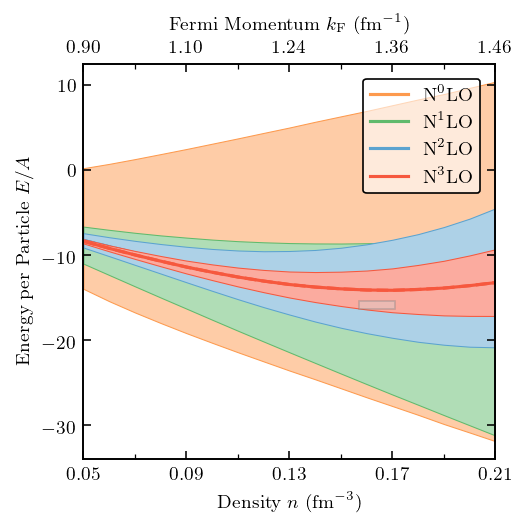

In [41]:
analyses[sym_nuclear, body23_appended].plot_observables(show_excluded=True, show_process=True, breakdown=Lb)

In [42]:
assert False

AssertionError: 

In [ ]:
def create_breakdown_df(analyses, body_types, obs_type):
    df_Lb_pdfs = pd.concat([analyses[obs_type, n_body].df_breakdown for n_body in body_types])
#     df_Lb_pdfs['$k_F$'] = kf_type_name
    grouped = df_Lb_pdfs[(df_Lb_pdfs['Body'] != body23) & (df_Lb_pdfs['Body'] != body23_appended)].groupby(
        ['$\Lambda_b$ (MeV)', 'Order', 'system'], sort=False
    )
    prod_df = grouped.prod().reset_index()
    prod_df['Body'] = 'Total'
    
    new_df = pd.concat([df_Lb_pdfs, prod_df], sort=False)
    # For appended 3N orders
#     order_fixes = {'N$^4$LO': 'N$^2$LO', 'N$^5$LO': 'N$^3$LO'}
#     new_df['Order'] = new_df['Order'].replace(order_fixes)
    
    return new_df

In [ ]:
df_Lb_pdfs_n = create_breakdown_df(analyses, body_types, pure_neutron)
df_Lb_pdfs_s = create_breakdown_df(analyses, body_types, sym_nuclear)
df_Lb_pdfs_d = create_breakdown_df(analyses, body_types, s2_energy)


df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d])


for obs_type, df_lb_i in zip(obs_types, [df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d]):
    fig, ax = plt.subplots(figsize=(3.4, 4.4))
    ax = pdfplot(
        x=r'$\Lambda_b$ (MeV)', y='Body', pdf='pdf', data=df_lb_i, hue='Order',
        order=[*body_types[:-1], 'Total', body_types[-1]],
        hue_order=[r'N$^2$LO', r'N$^3$LO'],
        cut=1e-2, linewidth=1,
            palette="coolwarm", saturation=1., ax=ax, margin=0.3,
    )
    ax.set_xlim(0, 1200)
    ax.set_xticks([0, 300, 600, 900, 1200])
    ax.grid(axis='x')
    ax.set_title(f'{obs_type}')
    ax.set_axisbelow(True)
    plt.show()
#     fig.savefig(f'breakdown_obs-{obs_type}')

In [ ]:
savefigs_diagnostics = True

In [ ]:
df_Lb_pdf_all = df_Lb_pdfs_n.copy()
df_Lb_pdf_all['pdf'] = df_Lb_pdfs_n['pdf'] * df_Lb_pdfs_s['pdf'] * df_Lb_pdfs_d['pdf']
df_Lb_pdf_all['system'] = 'All'
df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d, df_Lb_pdf_all])

fig, ax = plt.subplots(figsize=(3.4, 4.4))
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf[df_Lb_pdf['Body'] == 'Total'], hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
# ax.set_title(f'{obs_type}')
ax.set_axisbelow(True)
plt.show()
if savefigs_diagnostics:
    fig.savefig(f'breakdown_2n-3n-product_Lambda_{Lambda}')

In [ ]:
df_Lb_pdf_all = df_Lb_pdfs_n.copy()
df_Lb_pdf_all['pdf'] = df_Lb_pdfs_n['pdf'] * df_Lb_pdfs_s['pdf'] * df_Lb_pdfs_d['pdf']
df_Lb_pdf_all['system'] = 'All'
df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d, df_Lb_pdf_all])

fig, ax = plt.subplots(figsize=(3.4, 4.4))
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf[df_Lb_pdf['Body'] == 'Total'], hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
# ax.set_title(f'{obs_type}')
ax.set_axisbelow(True)
plt.show()
if savefigs_diagnostics:
    fig.savefig(f'breakdown_2n-3n-product_Lambda_{Lambda}')

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf[df_Lb_pdf['Body'] == 'Appended'], hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
# ax.set_title(f'{obs_type}')
ax.set_axisbelow(True)
plt.show()
if savefigs_diagnostics:
    fig.savefig(f'breakdown_3n-appended_Lambda_{Lambda}')

In [ ]:
lb_max_mask = \
    (df_Lb_pdf['Body'] == 'Appended') & \
    (df_Lb_pdf['system'] == 'All') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx = df_Lb_pdf[lb_max_mask]['pdf'].idxmax()
lb_map = df_Lb_pdf[lb_max_mask].loc[lb_max_idx]['$\Lambda_b$ (MeV)']

In [ ]:
lb_map

In [ ]:
lb_max_s_mask = \
    (df_Lb_pdf['Body'] == 'Appended') & \
    (df_Lb_pdf['system'] == '$E/A$') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx_s = df_Lb_pdf[lb_max_s_mask]['pdf'].idxmax()
lb_map_s = df_Lb_pdf[lb_max_s_mask].loc[lb_max_idx_s]['$\Lambda_b$ (MeV)']

In [ ]:
lb_map_s

In [ ]:
analyses[s2_energy, body23_appended].df_joint

In [ ]:
ls_map_vals = {}
for obs_type, n_body in product(obs_types, body_types):
#     fig, ax = plt.subplots()
    print(f'obs: {obs_type}, Body: {n_body}')
    if n_body == body23_appended:
        midx = 3
        ls_map_i = analyses[obs_type, n_body].compute_best_length_scale_for_breakdown(lb_map, midx)
        ls_map_vals[obs_type] = ls_map_i
        print(ls_map_i)
    else:
        midx = 3
    fig = analyses[obs_type, n_body].plot_joint_breakdown_ls(max_idx=midx)
    fig.suptitle(f'{obs_type}, {n_body}', y=3)
    plt.show()

In [ ]:
Q_n_map = ratio_kf(kf_n, breakdown=lb_map)
Q_s_map = ratio_kf(kf_s, breakdown=lb_map)
Q_d_map = ratio_kf(kf_d, breakdown=lb_map)

In [ ]:
coeffs_n_appended_map = gm.coefficients(y_n_appended, ratio=Q_n_map, ref=ref_2bf, orders=orders_appended)
coeffs_s_appended_map = gm.coefficients(y_s_appended, ratio=Q_s_map, ref=ref_2bf, orders=orders_appended)
coeffs_d_appended_map = gm.coefficients(y_d_appended, ratio=Q_d_map, ref=ref_2bf, orders=orders_appended)

In [ ]:
hyperparams

In [ ]:
order_labels_appended = [fr'$c_{{{n}}}^{{({b})}}$' for n, b in zip(orders_appended, [2, 2, 2, 3, 2, 3])]

In [ ]:
cmap_list_names_appended = ['Oranges', 'Greens', 'Blues', 'Blues', 'Reds', 'Reds']
cmap_list_appended = [plt.get_cmap(c) for c in cmap_list_names_appended]
color_list_appended = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmap_list_appended)]

In [ ]:
order_labels_appended

In [ ]:
from nuclear_matter.graphs import lighten_color

In [ ]:
def diagnostics_for_2bf_and_3bf(X, c, orders, train, valid, order_labels, colors, density, **kwargs):
    gp = gm.ConjugateGaussianProcess(**kwargs)
    gp.fit(X[train], c[train])
    cov = gp.cov(X[valid])
    print(gp.cbar_sq_mean_, gp.kernel_)
    gp_std = gp.cbar_sq_mean_
    interp_c, interp_std = gp.predict(X, return_std=True)
    mean = np.zeros(cov.shape[0])
    
    fig = plt.figure(figsize=(7.0, 2.5), constrained_layout=True)
    spec = fig.add_gridspec(nrows=1, ncols=7)
    ax_cs = fig.add_subplot(spec[:, :3])
    ax_md = fig.add_subplot(spec[:, 3])
    ax_pc = fig.add_subplot(spec[:, 4:])
    
#     markeredgecolors = [None, None, None, '0.3', None, '0.3']
    markeredgecolors = colors
#     markerlinestyles = ['-', '-', '-', '--', '-', '--']
    markerlinestyles = ['-', '-', '-', '-', '-', '-']
    markerfillstyles = ['full', 'full', 'full', 'left', 'full', 'left']
    markers = ['^', 'X', 'o', 'o',  's', 's']
    markerfacecolors = colors
    markerfacecoloralts = np.array(colors).copy()
    markerfacecoloralts[3] = mpl.colors.to_rgba('w')
    markerfacecoloralts[5] = mpl.colors.to_rgba('w')
    
    i = 0
#     x = X.ravel()
    x = density
    for n, c_n, label, color, ec, ls in zip(orders, c.T, order_labels, colors, markeredgecolors, markerlinestyles):
        ax_cs.plot(
            x, c_n, c=color, label=label, ls=ls, zorder=i/10, markevery=train, marker=markers[i],
            markeredgecolor=ec, fillstyle=markerfillstyles[i], markerfacecoloralt=markerfacecoloralts[i],
            markeredgewidth=0.5,
        )
        light_color = lighten_color(color)
        ax_cs.fill_between(
            x, interp_c[:, i] + 2*interp_std, interp_c[:, i] - 2*interp_std,
            facecolor=light_color, edgecolor=color, zorder=(i-0.5)/10, alpha=1
        )
#         ax_cs.scatter(
#             X[train].ravel(), c_n[train], c=color, edgecolor=ec, linestyle=ls,
#             linewidth=0.5, zorder=(i+0.5)/10
#         )
        ax_cs.axhline(0, 0, 1, c='k', lw=0.8, zorder=-1)
        ax_cs.axhline(+2*gp_std, 0, 1, c='lightgrey', lw=0.8, zorder=-1)
        ax_cs.axhline(-2*gp_std, 0, 1, c='lightgrey', lw=0.8, zorder=-1)
        i += 1
#     ax_cs.set_xlabel(r'$k_F$ [fm$^{-1}$]')
    ax_cs.set_xlabel(r'$n$ [fm$^{-3}$]')
    ax_cs.set_xticks(x[train], minor=False)
    ax_cs.set_xticks(x[valid], minor=True)
    ax_cs.legend(ncol=3)
    
    graph = gm.GraphicalDiagnostic(
        c[valid], mean=mean, cov=cov, markeredgecolors=markeredgecolors,
        colors=colors, markerfillstyles=markerfillstyles, markers=markers
    )
    graph.md_squared(type='box', trim=True, title=None, ax=ax_md)
    graph.pivoted_cholesky_errors(ax=ax_pc)
    
    bbox = dict(facecolor='w', boxstyle='round', alpha=0.7)
    ax_pc.text(0.05, 0.95, r'${\rm D}_{\rm PC}$', ha='left', va='top', bbox=bbox, transform=ax_pc.transAxes)
    ax_pc.set_title('')
    from matplotlib.ticker import MaxNLocator
    ax_pc.yaxis.set_major_locator(MaxNLocator(integer=True))
    return fig


def plot_cbar_ell_correlation(X, c, orders, train, ls_vals, **kwargs):
    gp = gm.ConjugateGaussianProcess(**kwargs)
    gp.fit(X[train], c[train])
    loglike = np.array([gp.log_marginal_likelihood(theta=np.log(ls)) for ls in ls_vals])
    

In [ ]:
coeff_noise_n = 1e-2
coeff_noise_s = 1e-2
coeff_noise_d = 1e-2

valid2 = [i % 4 != 0 for i in range(len(density))]

In [ ]:
hyperparams

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig = diagnostics_for_2bf_and_3bf(
        Kf_n, coeffs_n_appended, orders_appended, train, valid2, order_labels_appended,
        colors=color_list_appended, density=density,
        kernel=RBF(ls_map_vals[pure_neutron]) + WhiteKernel(coeff_noise_n**2, noise_level_bounds='fixed'),
        decomposition='eig',
#         decomposition='cholesky',
#         kernel=RBF(0.9) + WhiteKernel(coeff_noise**2, noise_level_bounds='fixed'),
#         optimizer=None,
        **hyperparams
#         center=0, disp=0, sd=0.5
    );
    plt.show()
    if savefigs_diagnostics:
        fig.savefig(f'diagnostics_3n-appended_system-n_Lambda_{Lambda}')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig = diagnostics_for_2bf_and_3bf(
        Kf_s, coeffs_s_appended, orders_appended, train, valid, order_labels_appended,
        colors=color_list_appended, density=density,
        kernel=RBF(ls_map_vals[sym_nuclear]/2) + WhiteKernel(coeff_noise_s**2, noise_level_bounds='fixed'),
        decomposition='eig',
#         decomposition='cholesky',
#         optimizer=None,
        **hyperparams
    )
    plt.show()
    if savefigs_diagnostics:
        fig.savefig(f'diagnostics_3n-appended_system-s_Lambda_{Lambda}')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig = diagnostics_for_2bf_and_3bf(
        Kf_d, coeffs_d_appended, orders_appended, train, valid, order_labels_appended,
        colors=color_list_appended, density=density,
        kernel=RBF(ls_map_vals[s2_energy]) + WhiteKernel(coeff_noise_d**2, noise_level_bounds='fixed'),
        decomposition='eig',
#         decomposition='cholesky',
#         optimizer=None,
        **hyperparams
    )
    plt.show()
    if savefigs_diagnostics:
        fig.savefig(f'diagnostics_3n-appended_system-d_Lambda_{Lambda}')